In [32]:
%pylab inline
lamda=1; eta=.9; alpha=.4; beta=.5; d1=d2=gamma=0.1

##be careful, lamda is a rate, eta is a probability!
#lamda is (l1=rate of interaction Y+X->Y+Y)+(l2=rate of Y+X->Y+Z), so lamda=l1+l2, eta=l1/l1+l2

#[50,200,500,2000]
tot=1000 #number of nodes
houses=1000
house_size=tot//houses  #[5,50,100] households
medians=[(house_size//2)+house_size*i for i in range(0,tot//house_size)]

init_spread=0.1 #initial spreaders percentage
print(medians)

T=300
t=0
max_it=10000

Populating the interactive namespace from numpy and matplotlib
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 2

/home/simone/anaconda3/envs/python_env/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'gamma']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [33]:
def delta(status,desired): #returns 0 if and only if status and desired are the same
    return int(status==desired)

In [34]:
class Node:
    def __init__(self, status):
        self.stat=status #status of the node:0=X,1=Y,2=Z
        self.neig=[]
        self.k=0
        self.kx=0
        self.omega=0 #total rate of transition of the node
        self.spontaneous=0  #rate of spontaneous transistion of the node
        
    def insert_neighbours(self,neigh):
        self.neig=neigh #list of neighbours
        self.k=size(neigh)
        
    def update(self, increment=0):
        self.kx+= increment 
        self.omega=self.myomega()
        self.spontaneous=self.spont()
    
    def myomega(self): #not normalized probability of being chosen,proportional to transition rate
        return delta(self.stat,1)*(self.kx*lamda+alpha*(self.k-self.kx)+d1+d2)+delta(self.stat,2)*(gamma+self.kx*beta)
    
    def spont(self): #rate of spontanous transitions
        return delta(self.stat,1)*(d1+d2)+delta(self.stat,2)*gamma

In [35]:
node=[]
for i in range(tot):
    r= 1 if np.random.rand(1)<init_spread else 0
    node.append(Node(r))
    
for i in range(tot):  #insert neighbours and fix k
    node[i].insert_neighbours(  [j for j in range(    house_size*(i//house_size),house_size*(1+i//house_size)) if j!=i]
                              + [m for m in medians if (i in medians)and(m!=i)])
    
for i in range(tot): #fix kx,omega, spontaneous rate
    node[i].update(size([node[j] for j in node[i].neig if node[j].stat==0]))
    
#print([i for i in range(tot) if node[i].stat==1])
#print([node[i].kx for i in range(tot)])
W=sum([node[i].omega for i in range(tot)])
W
Nx=sum([node[i].stat==0 for i in range(tot)])
Ny=sum([node[i].stat==1 for i in range(tot)])

## SIMULATOR, Improved Rejection sampling with node-based method

In [36]:
#this function choose a node randomly and accepts it with probability proportional to its total rate (omega[i])
def choose_node():
    while(True):
        r2,i= np.random.rand(2)
        i=int(i*tot) #extracted node
        if(node[i].omega>r2*W):
            return i
        
        
##choose noded version2:
def choose_node_2():
    probs=[node[i].omega for i in range(tot)]
    sorted_probs= sorted(((v, i) for i, v in enumerate(probs)), reverse=True)

    cumulates = np.cumsum([item[0] for item in sorted_probs])  
    r2=np.random.rand()*W

    for i, val in enumerate(cumulates):
        if r2 < val:
            idx=sorted_probs[i][1]
            if(node[idx].stat==0):
                print("what ", node[i].omega)
            return idx       

        
#this function represent a spontaneous process (nodes not interacting)
def spontaneous_transition(i):
    global Nx,Ny
    if(node[i].stat==0):
        print("Should not happen")
        return
    r=np.random.rand()
    if((node[i].stat==1)and(r*(d1+d2)<=d1)):  #case Y=>X with rate d1
        #print("Y to X")
        node[i].stat=0
        node[i].update(0)
        Nx+=1
        Ny-=1
        for n in node[i].neig:
            node[n].update(1) #all neighbours have 1 more X neighbours
        return
    elif((node[i].stat==1)and(r*(d1+d2)>d1)): #case Y=>Z rate d2
        #print("Y to Z")
        node[i].stat=2   #does not change kx of neighbours, so they do not need to be updated
        node[i].update(0)
        Ny-=1
        return
    #case Z=>X
    #print("Z to X")
    node[i].stat=0
    node[i].update(0)
    Nx+=1
    for n in node[i].neig:
        node[n].update(1)
    return
    
    
#this function simulate contact from node[i] to one of its neighbours  
def make_contact_from(i):
    global Nx,Ny
    n=random.choice(node[i].neig)
    if((node[i].stat==1)and(node[n].stat==0)): #Y+X 
        if(np.random.rand()<eta):  #Y+X=> Y+Y with prob eta
            node[n].stat=1
            Nx-=1
            Ny+=1
            for nn in node[n].neig:
                node[nn].update(-1) #all the neighbours of node[n] have 1 less X neighbour, me included
            return
        else:  #Y+X=>Y+Z with (1-eta)
            node[n].stat=2
            Nx-=1
            for nn in node[n].neig:
                node[nn].update(-1) #all the neighbours of node[n] have 1 less X neighbour, me included
            return
    elif(node[i].stat==1): #Y+ (Z or Y) => Z+ (Z or Y)
        node[i].stat=2
        Ny-=1
        node[i].update(0)   #No change in kx for me nor my neighbours
        return
    #if u arrive here, it means u are Z && kx!=0, so u can do contact transition of Z
    #Z+X->Y+X
    if(node[i].stat!=2):
        print("cosa che diamine")
    node[i].stat=1
    node[i].update()  #neighbours no need to update: kx is the same for them
    Ny+=1
    return

In [37]:
%%time 

results=[]
t=0
r=np.random.rand(2*max_it)
it=0

results.append((t,Nx,Ny,tot-(Nx+Ny)))

while((it<2*max_it)and (t<=T)):
    dt=-log(r[it])/W
    t+=dt
    i=choose_node_2()
    
    
    #print('node chosen', i)
    if(i==None):
        print('end ',Nx,Ny,Nz)
        break
    
    if(r[it+1]*node[i].omega>node[i].spontaneous): 
        make_contact_from(i)
    else:
        spontaneous_transition(i)

    W=sum([node[j].omega for j in range(tot)])
    results.append((t,Nx,Ny,tot-(Nx+Ny)))
    it+=2
    if(it/2>max_it-5):
        print(it, max_it,'approaching max_it')
    if(T-t<0.5):
        print('approaching max t')

19992 10000 approaching max_it
19994 10000 approaching max_it
19996 10000 approaching max_it
19998 10000 approaching max_it
20000 10000 approaching max_it
CPU times: user 11.8 s, sys: 8.01 ms, total: 11.8 s
Wall time: 11.8 s


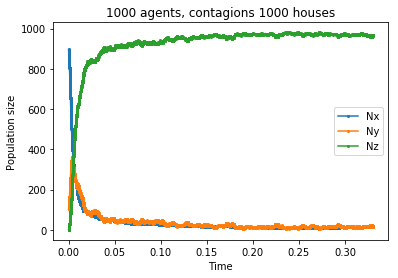

In [38]:
times= [item[0] for item in results]
Nx_plot= [item[1] for item in results]
Ny_plot= [item[2] for item in results]
Nz_plot= [item[3] for item in results]

ax = subplot(111)

ax.plot(times,Nx_plot,'-o',label='Nx',markersize=2)
ax.plot(times,Ny_plot,'-o',label='Ny',markersize=2)
ax.plot(times,Nz_plot,'-o',label='Nz',markersize=2)
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Population size')
plt.title(str(tot)+' agents, contagions '+str(houses)+' houses')
plt.savefig('only_spontaneous_'+str(tot)+'.png',dpi=200)
plt.show()

100 0 0
